# 1. Importing the neccesary libraries and packages

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import os
from tensorflow.keras.preprocessing.image import load_img
from torch.autograd import Variable

# 2. Loading and Splitting the dataset into a training and validation set


In [37]:
data_dir = '....../ML_Task/EuroSAT/2750/'

def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(64),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(64),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    # We split the datasets using SubsetRandomSampler 
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    # We choose 64 as batche size
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader,train_data


#Printing the classes names
trainloader, testloader,train_data = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


### - Visualize an example image from each category

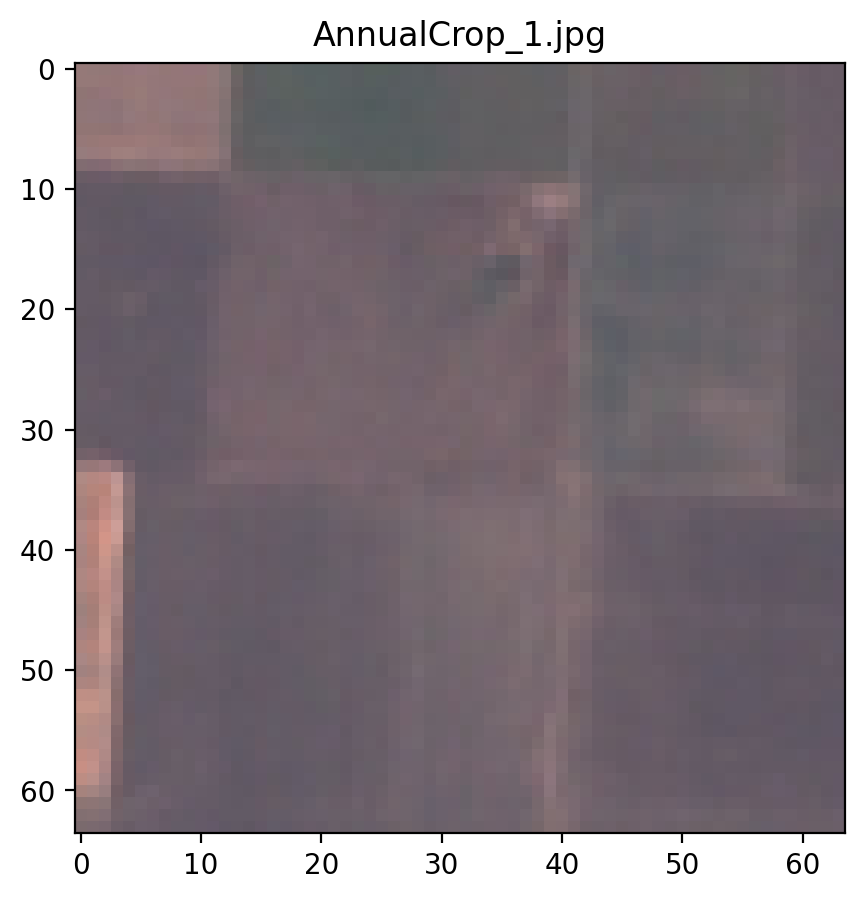

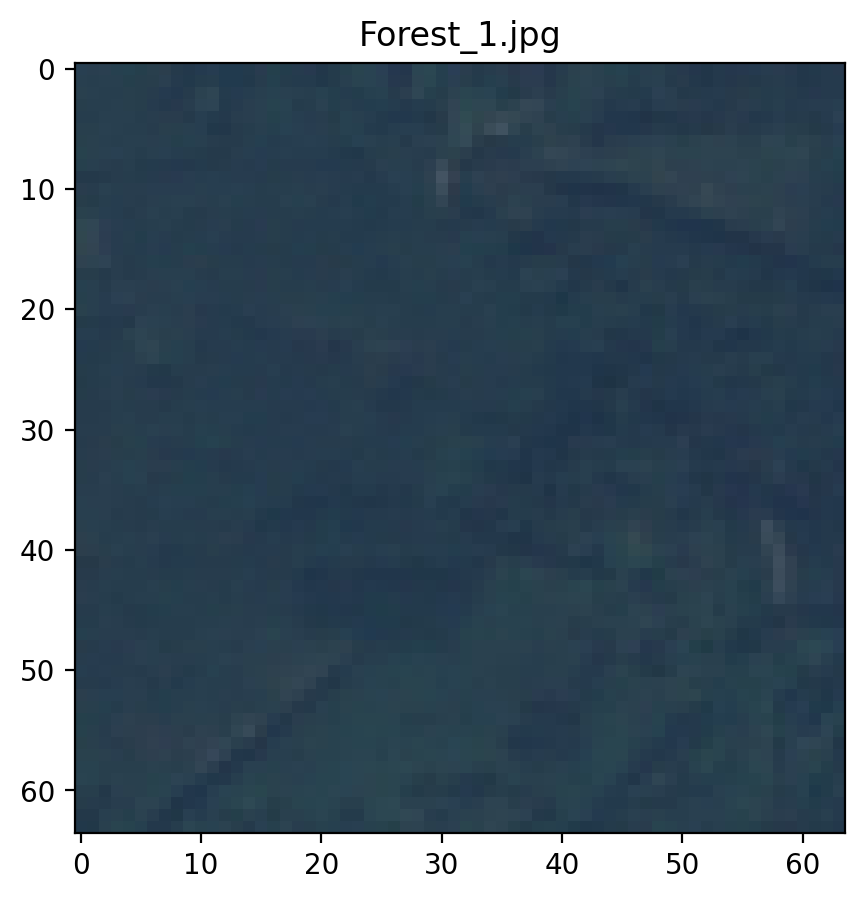

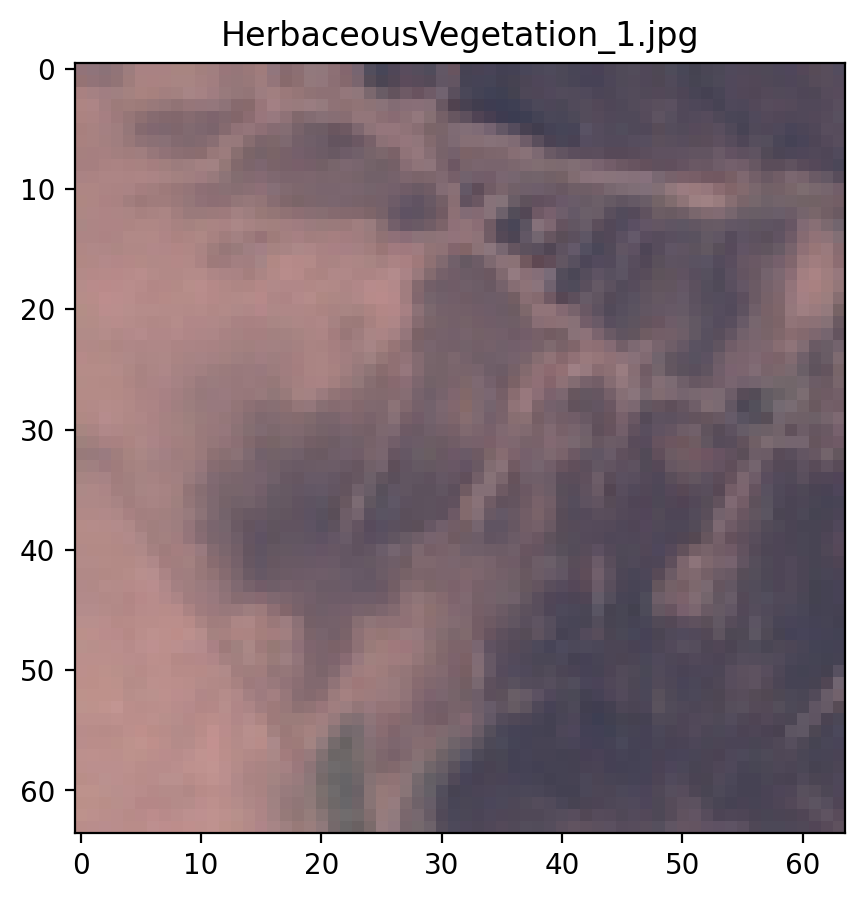

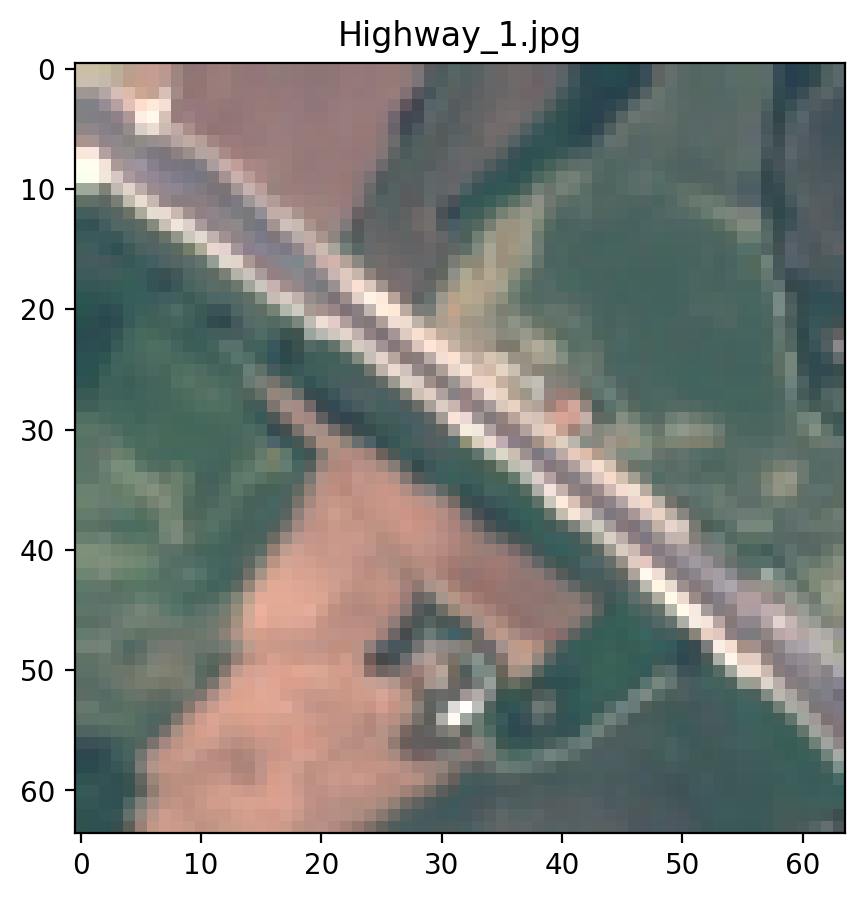

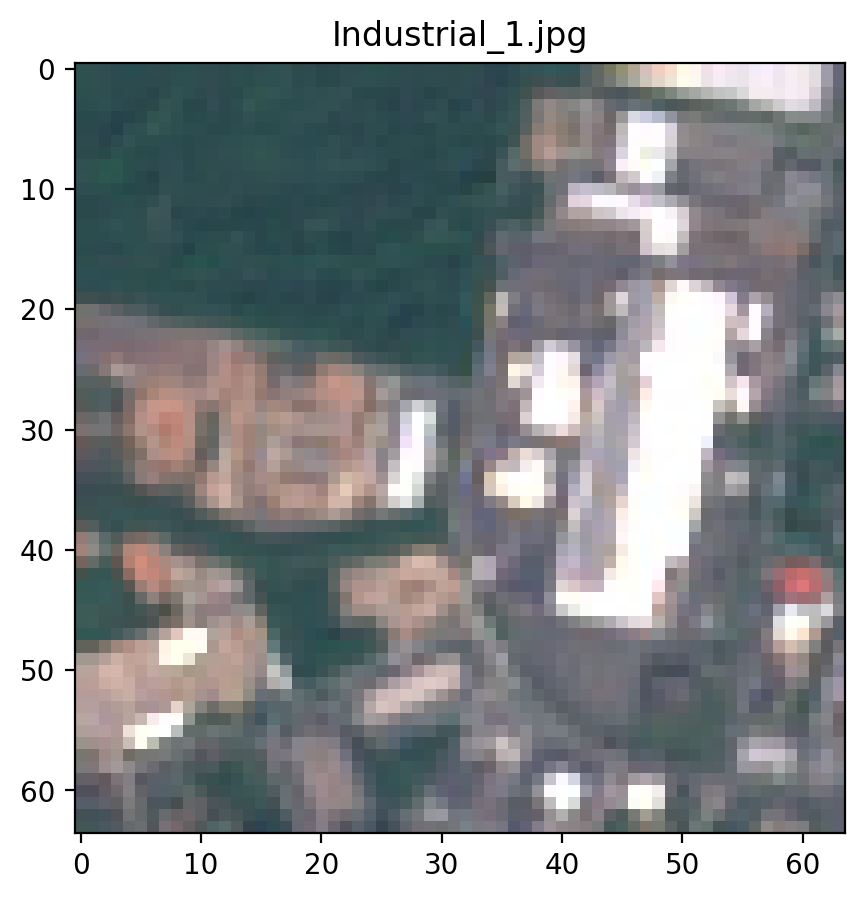

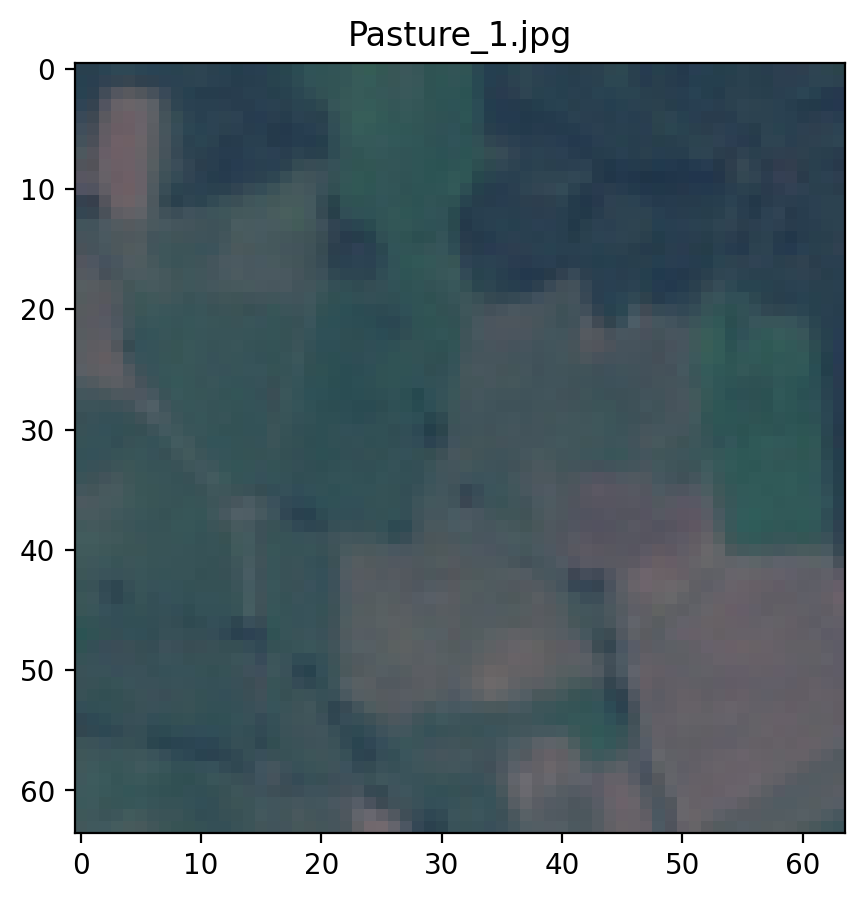

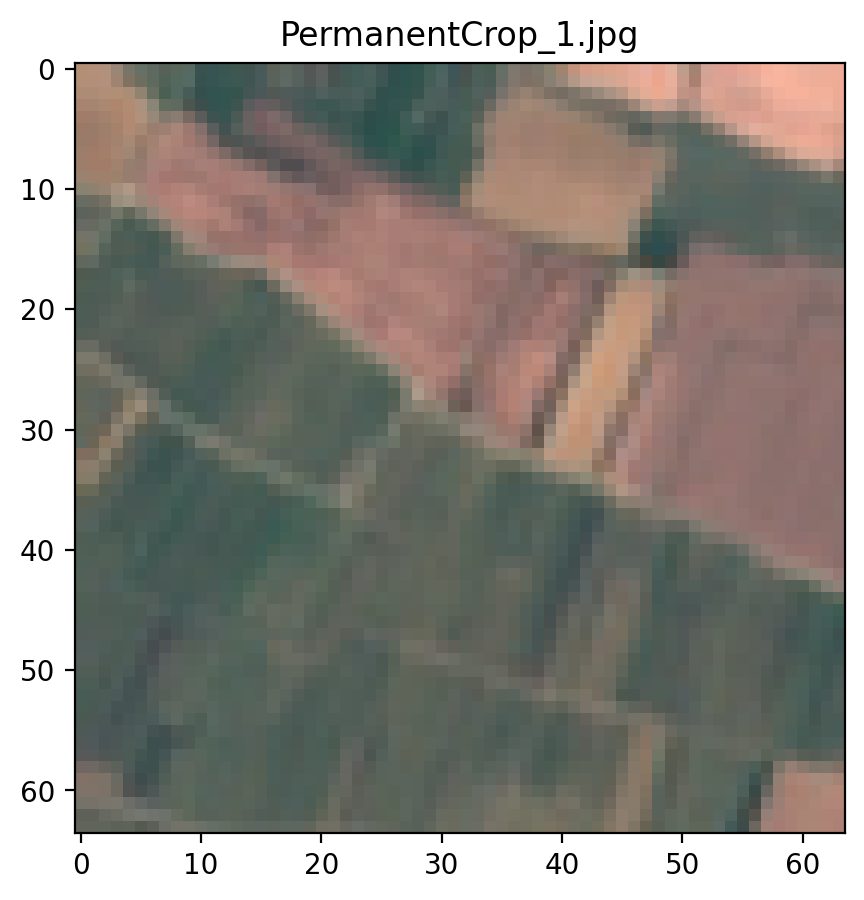

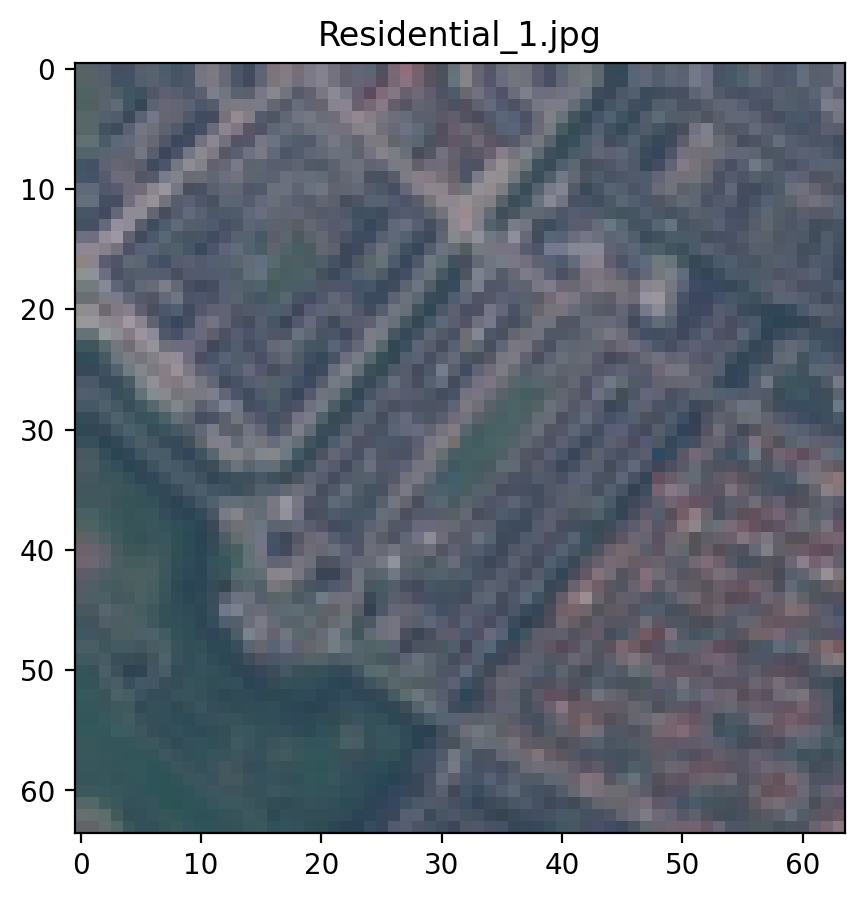

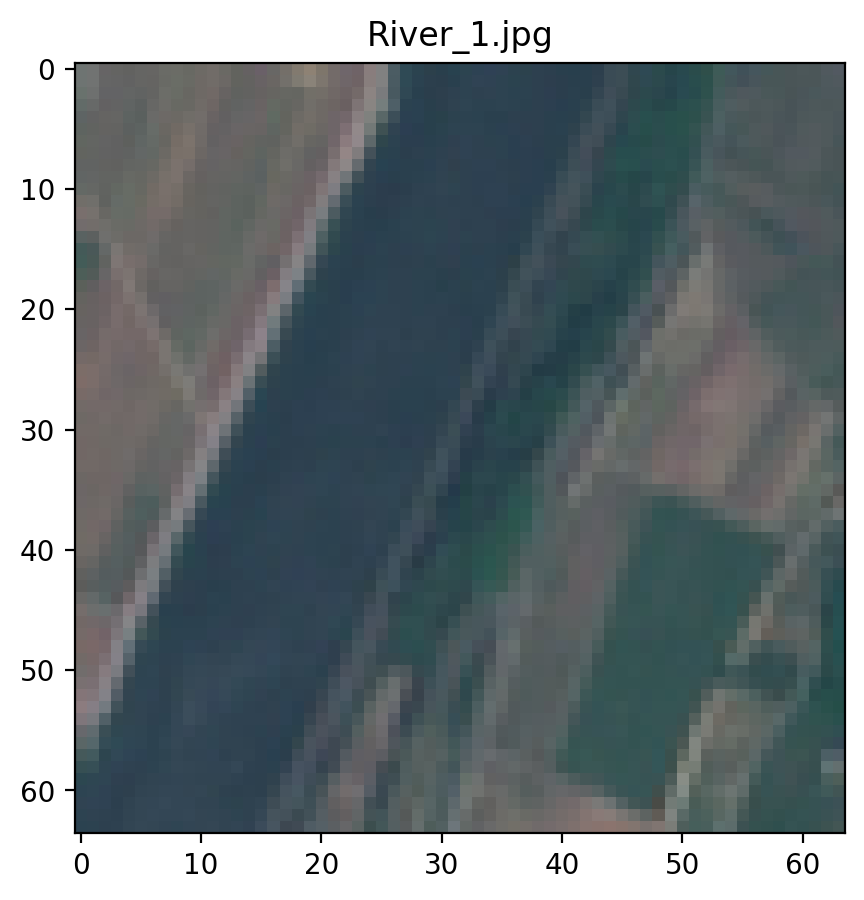

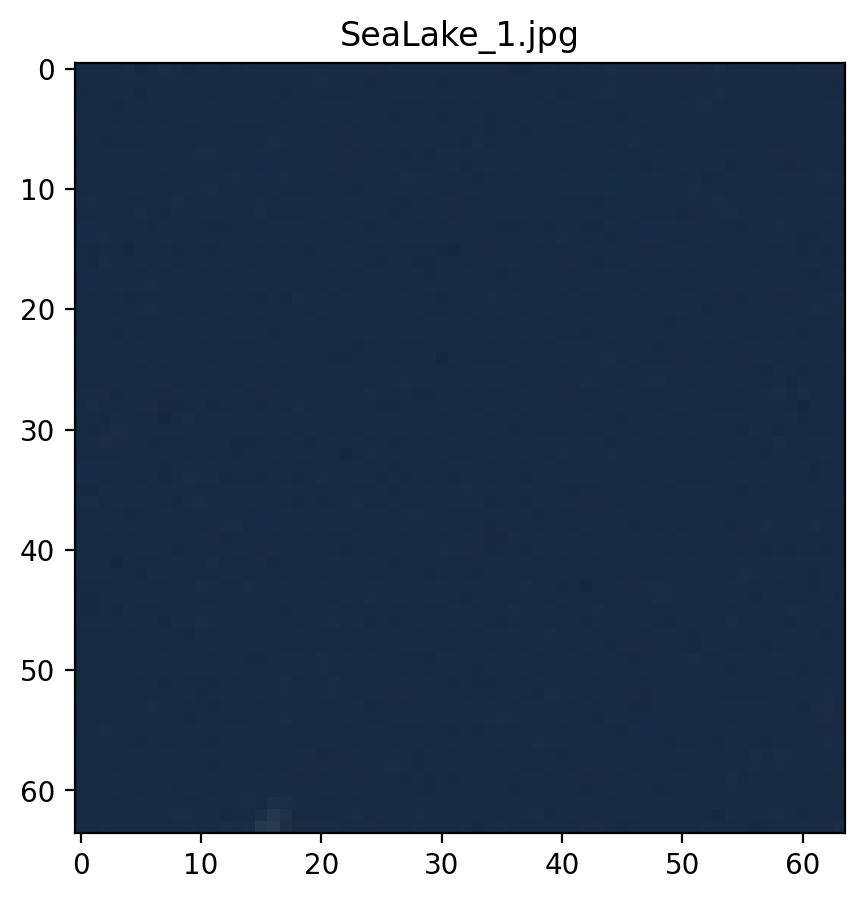

In [38]:
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        plt.rcParams["figure.figsize"] = (15,5)
        plt.figure()
        plt.title(file)
        plt.imshow(image)
        break
plt.show()

### Now we determine whether we have GPU or not --> generalize and check for the GPU availability


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

# 3. Loading a pretrained model 'ResNet 50'

In [39]:
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# We Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False
    
# We re-define the final fully-connected the layer,  
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))

# We also create the criterion (the loss function) and pick an optimizer (Adam in this case) and learning rate.
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

# 4. Training the model

In [41]:
# Only one epoch in this example (because it is time-consuming to add more due to relatively large dataset)
epochs = 1
steps = 0
running_loss = 0
print_every = 4
train_losses, test_losses = [], []

# We load the batches of images and do the feed forward loop
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # We calculate the loss function, and use the optimizer to apply gradient descent in back-propagation.
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
            
            
            
torch.save(model, 'LandUseandCover_Model.pth')
################################ --> Now the model is saved for later predictions!

Epoch 1/1.. Train loss: 3.283.. Test loss: 2.599.. Test accuracy: 0.221
Epoch 1/1.. Train loss: 2.419.. Test loss: 2.053.. Test accuracy: 0.325
Epoch 1/1.. Train loss: 1.468.. Test loss: 2.053.. Test accuracy: 0.319
Epoch 1/1.. Train loss: 1.191.. Test loss: 2.694.. Test accuracy: 0.395
Epoch 1/1.. Train loss: 0.966.. Test loss: 2.840.. Test accuracy: 0.356
Epoch 1/1.. Train loss: 0.960.. Test loss: 1.789.. Test accuracy: 0.531
Epoch 1/1.. Train loss: 0.985.. Test loss: 1.544.. Test accuracy: 0.586
Epoch 1/1.. Train loss: 0.860.. Test loss: 1.556.. Test accuracy: 0.535
Epoch 1/1.. Train loss: 0.859.. Test loss: 1.076.. Test accuracy: 0.643
Epoch 1/1.. Train loss: 0.746.. Test loss: 0.768.. Test accuracy: 0.760
Epoch 1/1.. Train loss: 0.626.. Test loss: 0.852.. Test accuracy: 0.727
Epoch 1/1.. Train loss: 0.721.. Test loss: 0.708.. Test accuracy: 0.781
Epoch 1/1.. Train loss: 0.559.. Test loss: 0.656.. Test accuracy: 0.791
Epoch 1/1.. Train loss: 0.720.. Test loss: 0.623.. Test accuracy

### Ploting the training and validation losses

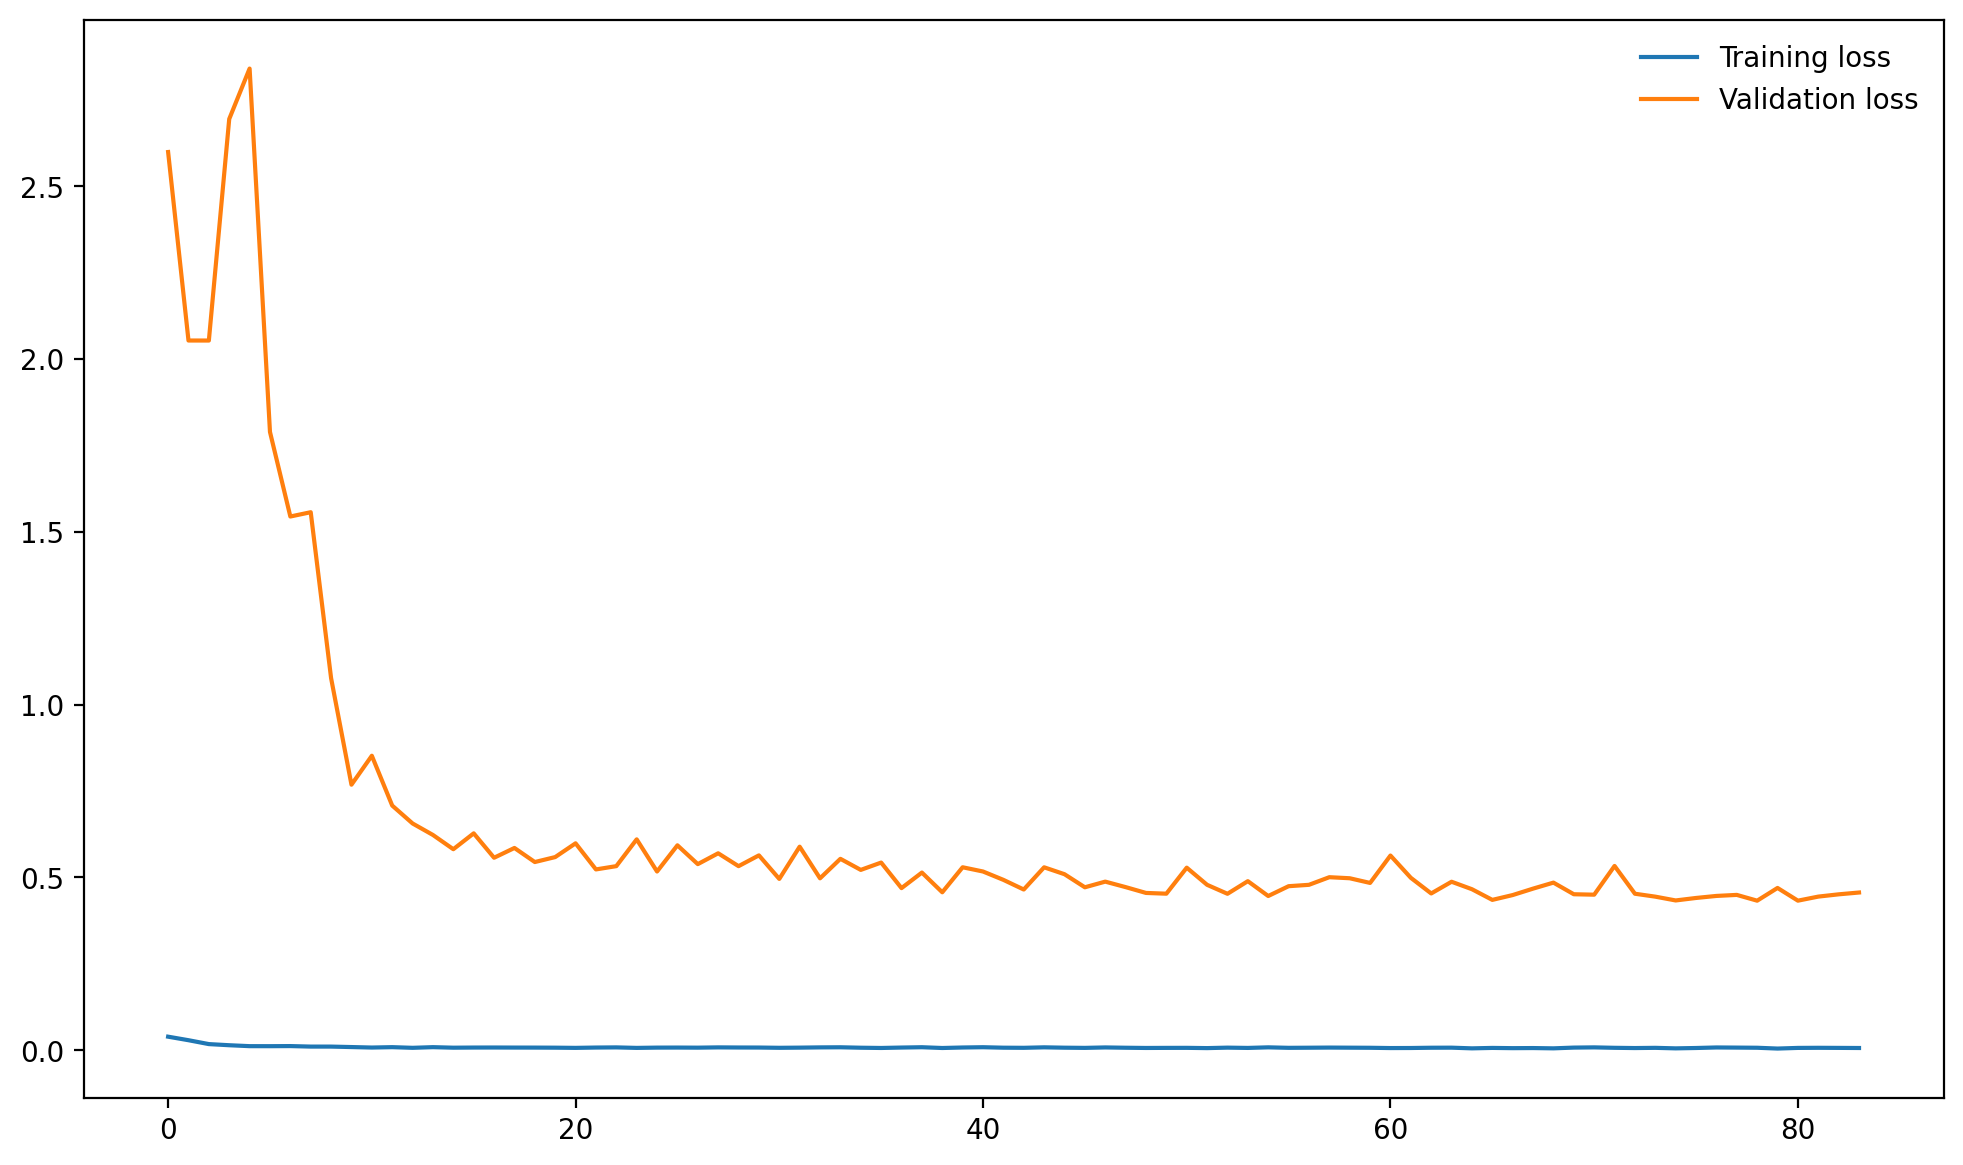

In [62]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# 5. Testing the model

## 5.1 Perform inference

In [43]:
data_dir = 'C:/Users/nourd/OneDrive/Desktop/Machine_Learning_Task/EuroSAT - Copy'
test_transforms = transforms.Compose([transforms.Resize(64),
                                      transforms.ToTensor(),
                                     ])

In [44]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('LandUseandCover_Model.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [45]:
def predict_image(image):
    '''
    This function that predicts the class of a specific image
    '''
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [46]:
def get_random_images(num):
    '''
    This function picks a number of random images from the dataset folders
    '''
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels,classes

## 5.2   Sample Images Prediction (20 images) & displaying results

C:\Users\nourd\AppData\Local\Temp\ipykernel_11184\2077003077.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


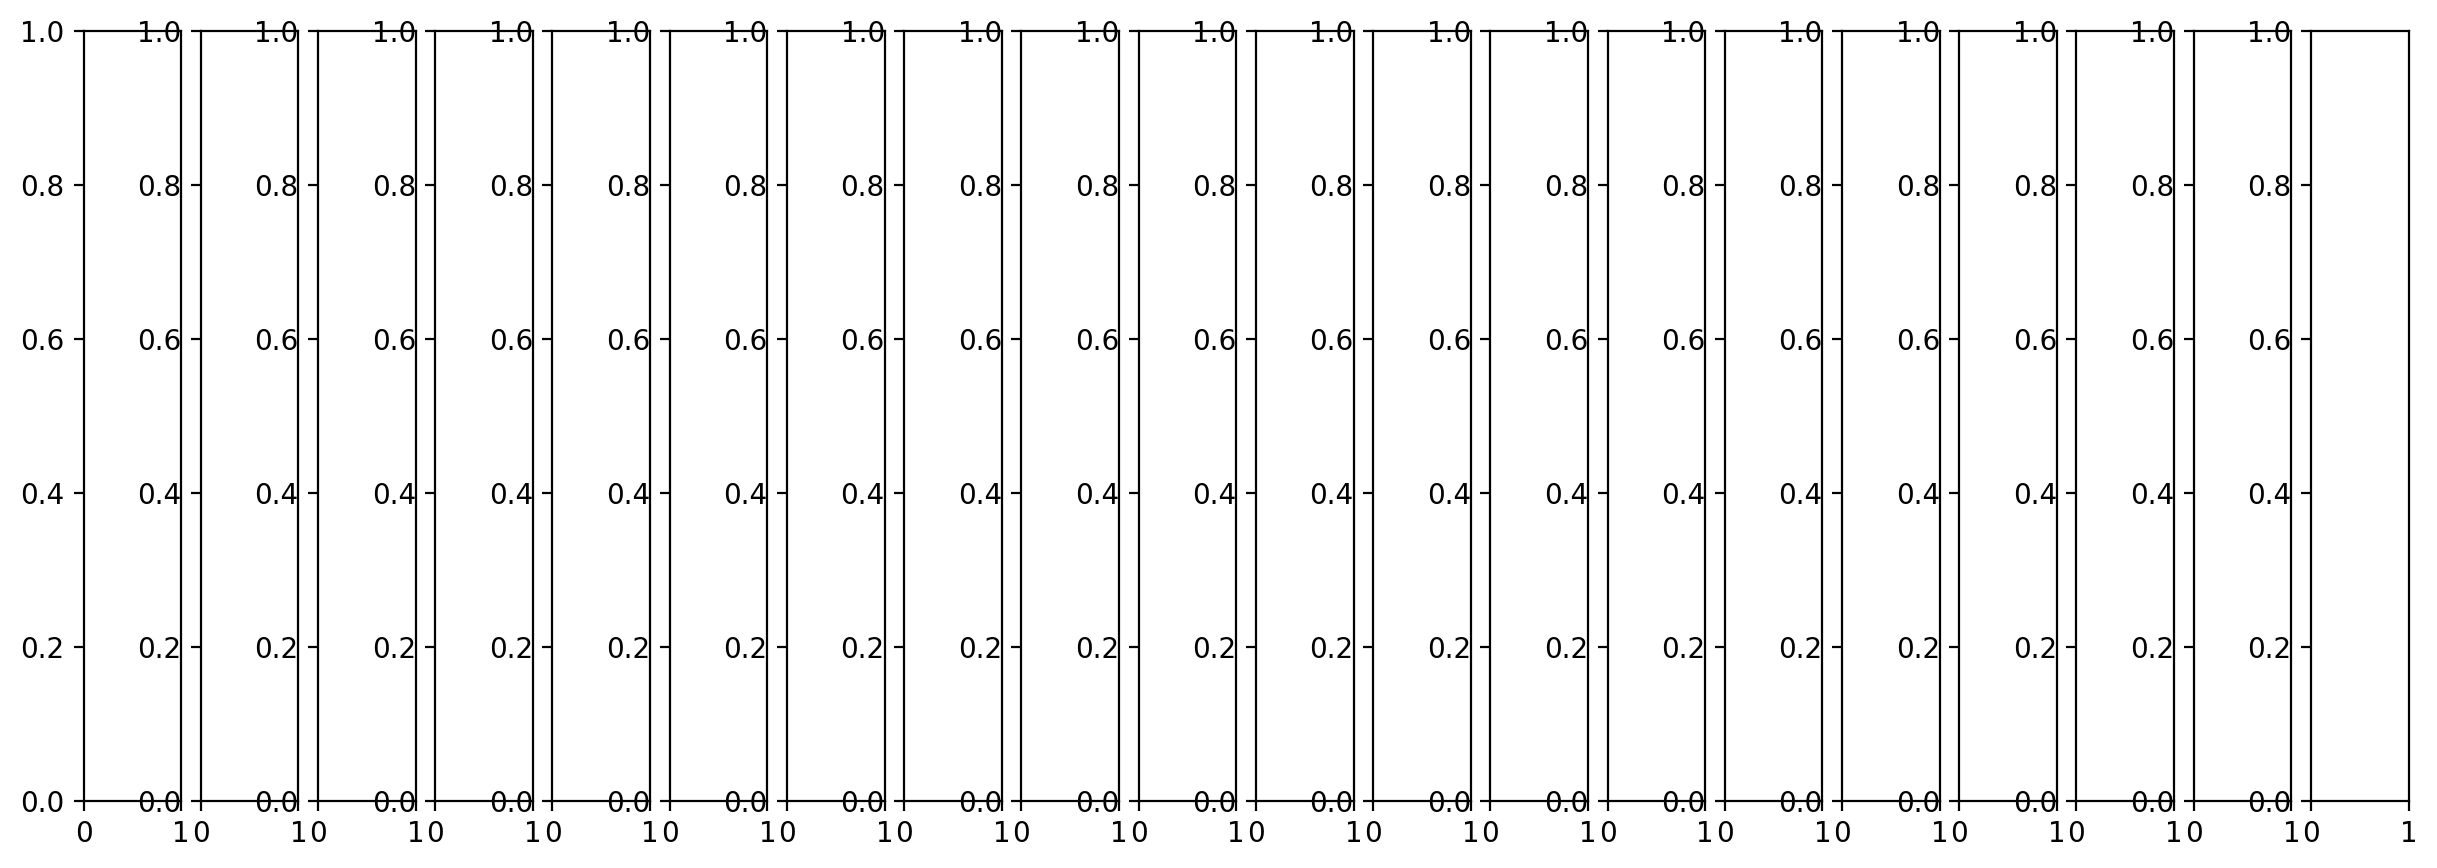

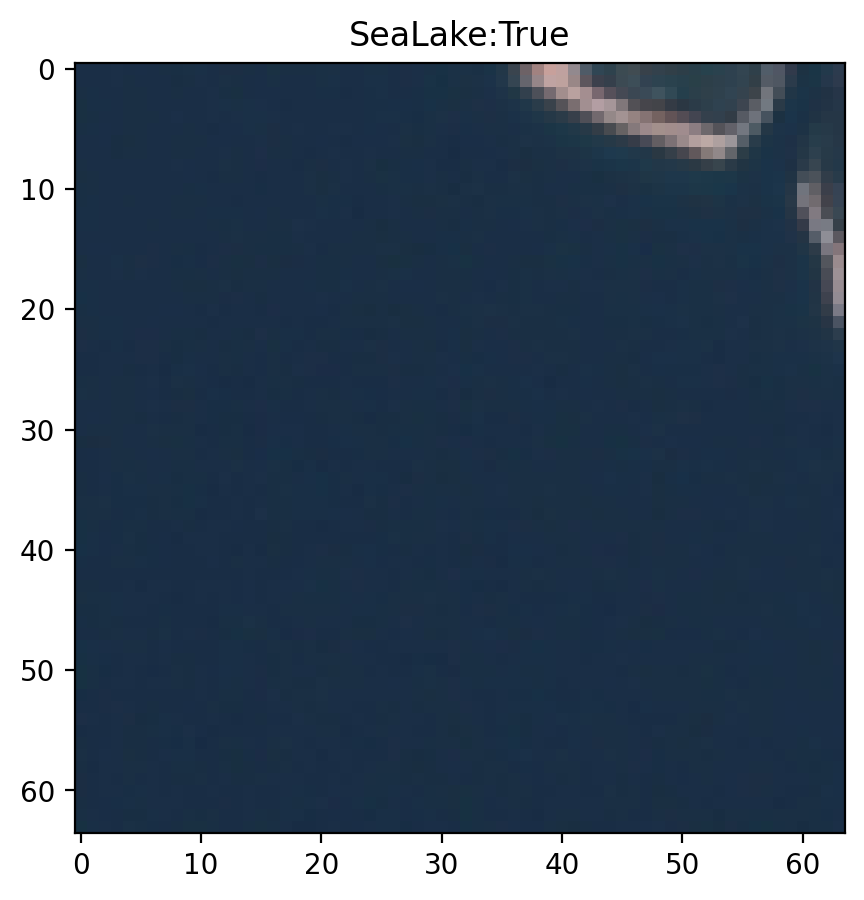

<Figure size 1500x500 with 0 Axes>

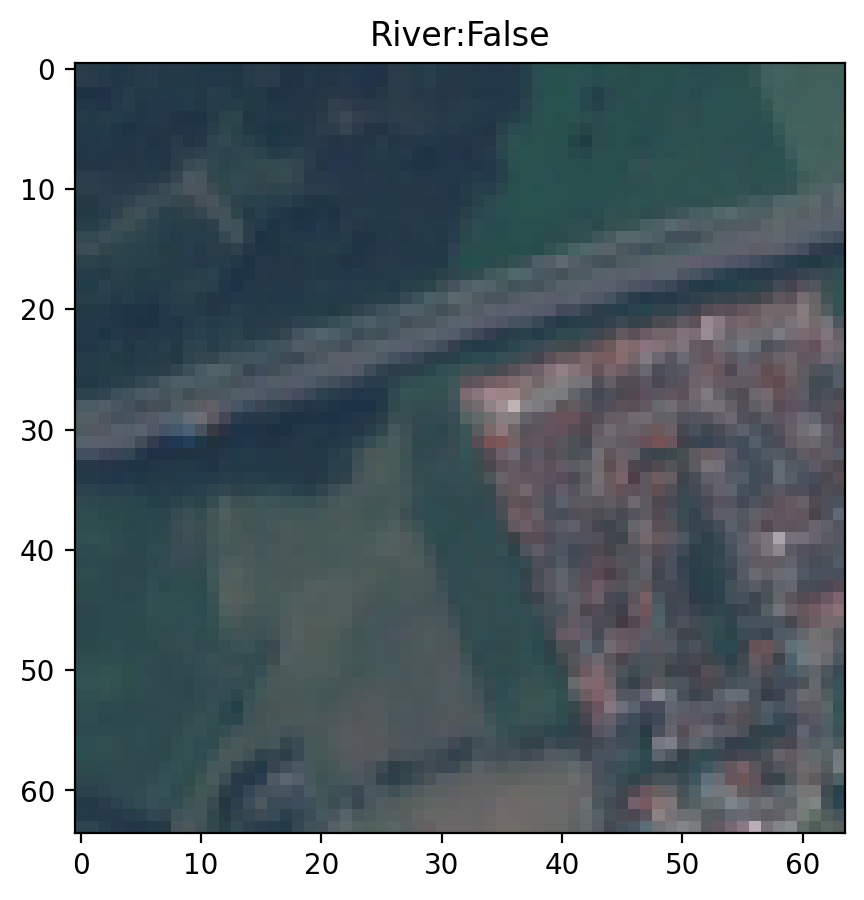

<Figure size 1500x500 with 0 Axes>

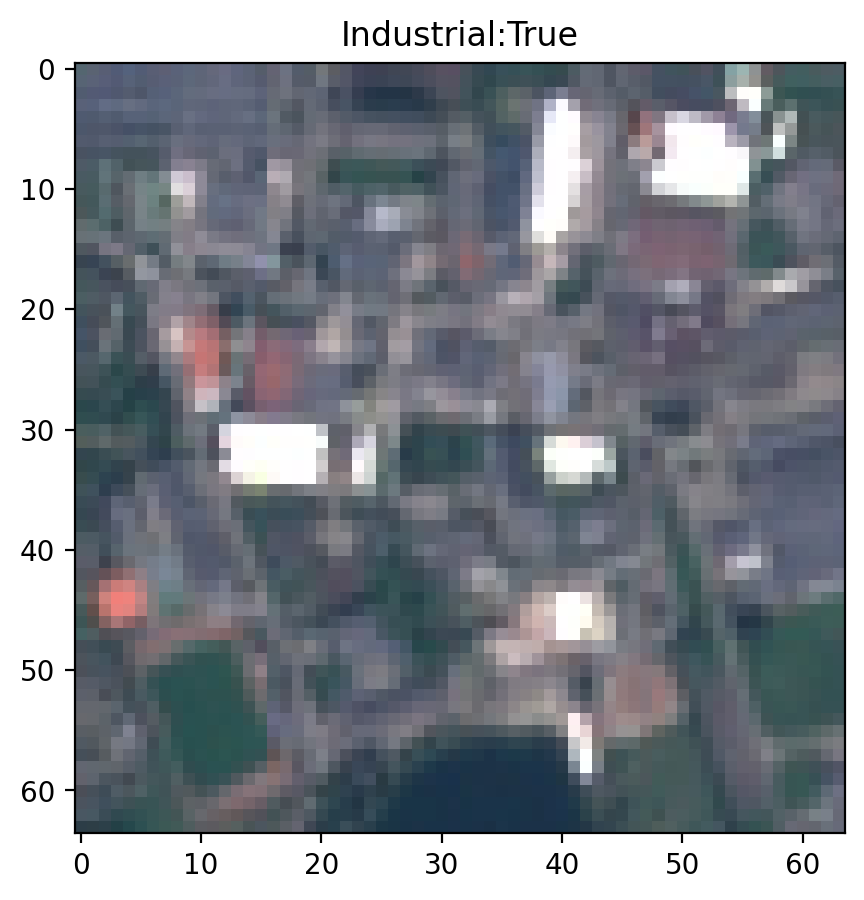

<Figure size 1500x500 with 0 Axes>

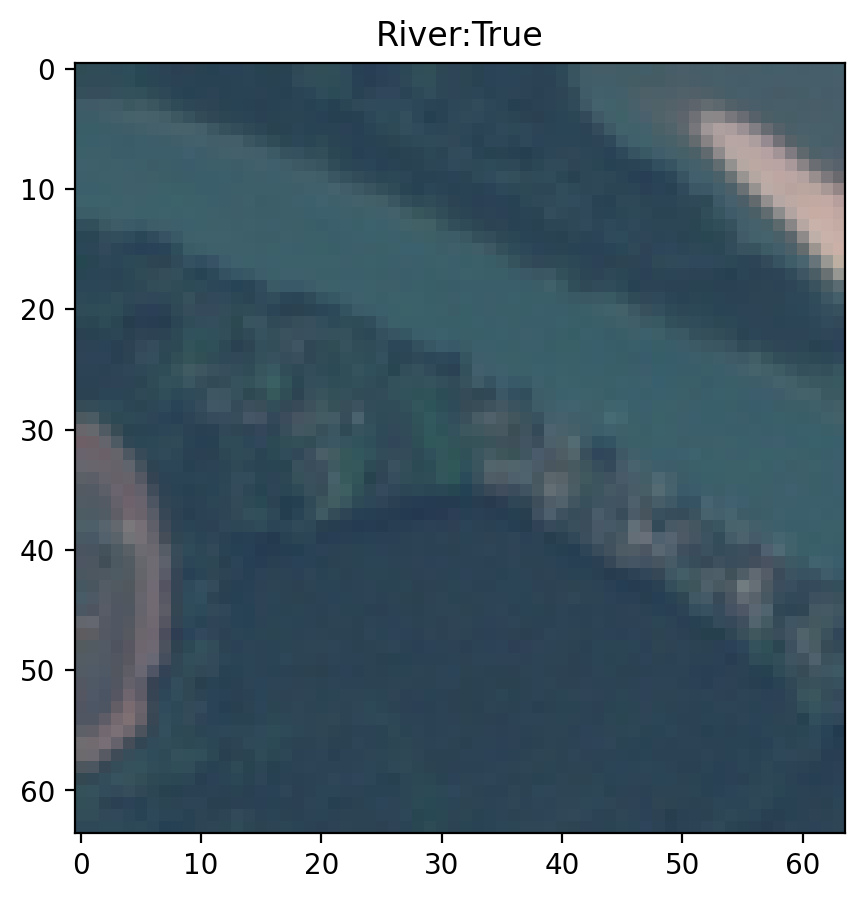

<Figure size 1500x500 with 0 Axes>

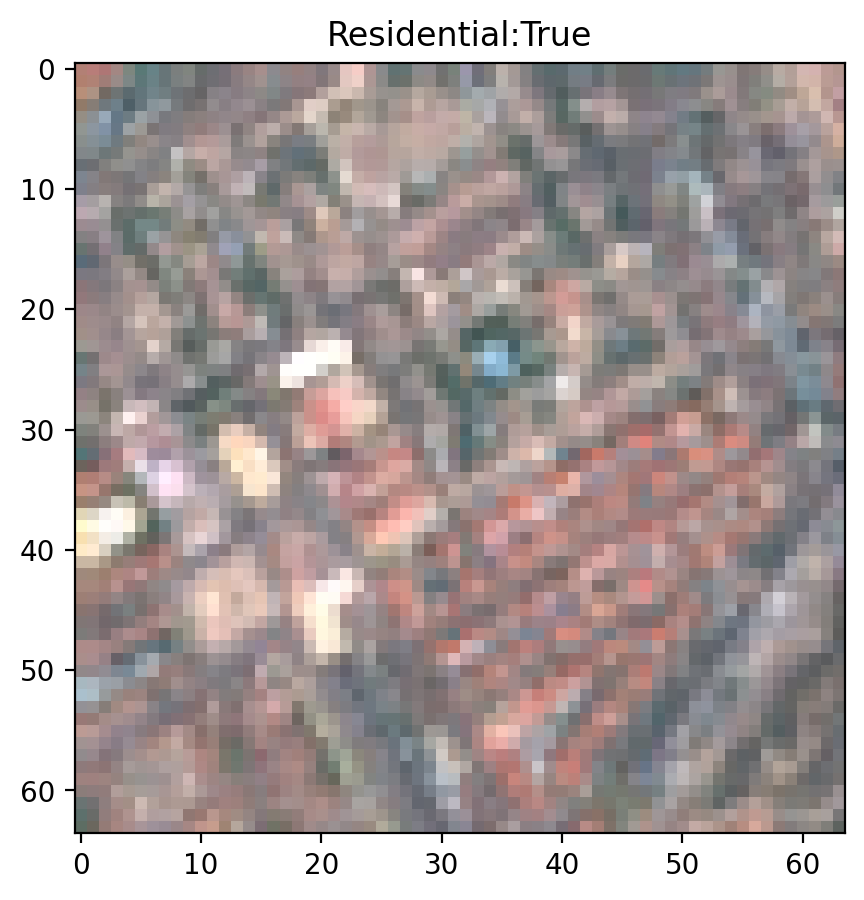

<Figure size 1500x500 with 0 Axes>

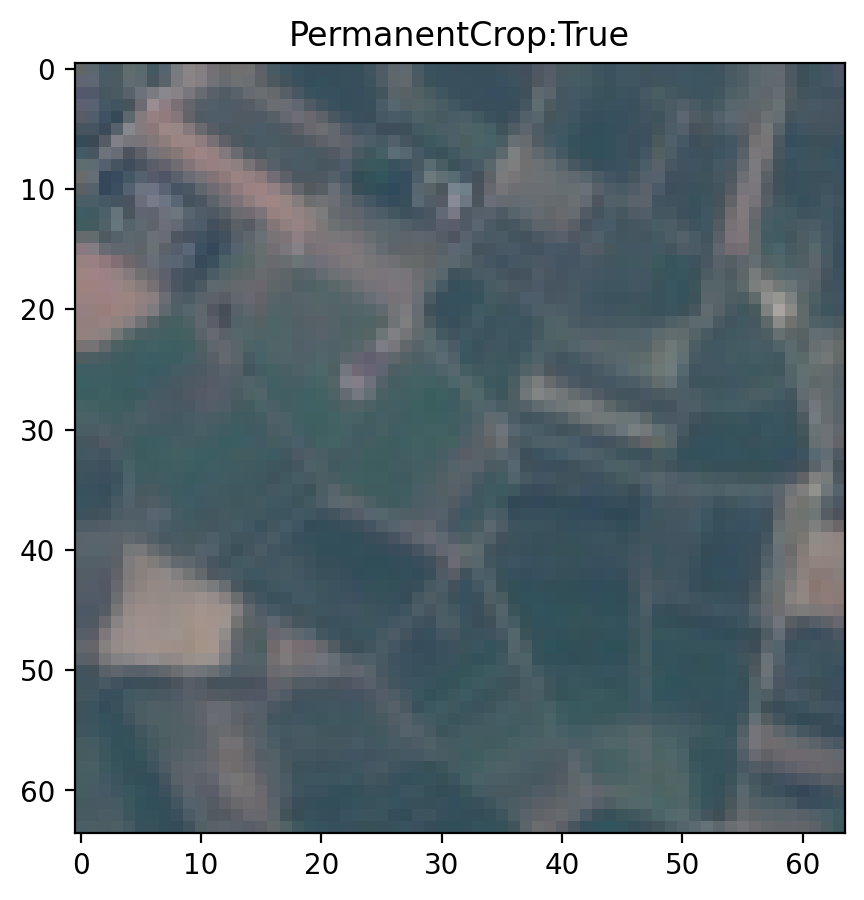

<Figure size 1500x500 with 0 Axes>

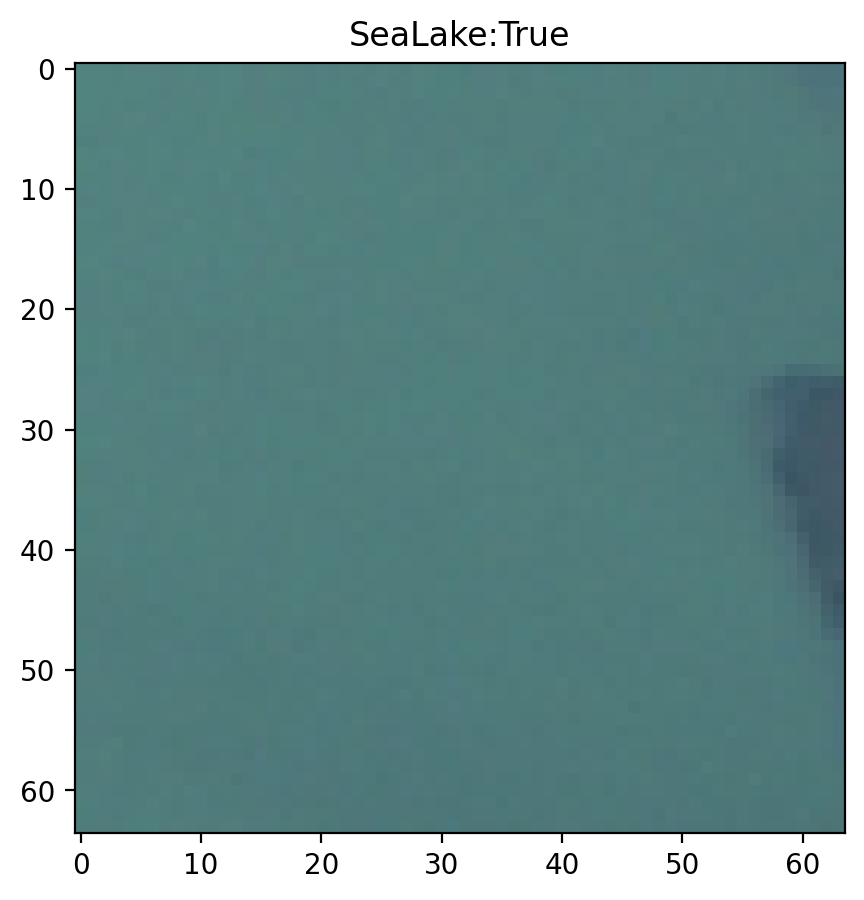

<Figure size 1500x500 with 0 Axes>

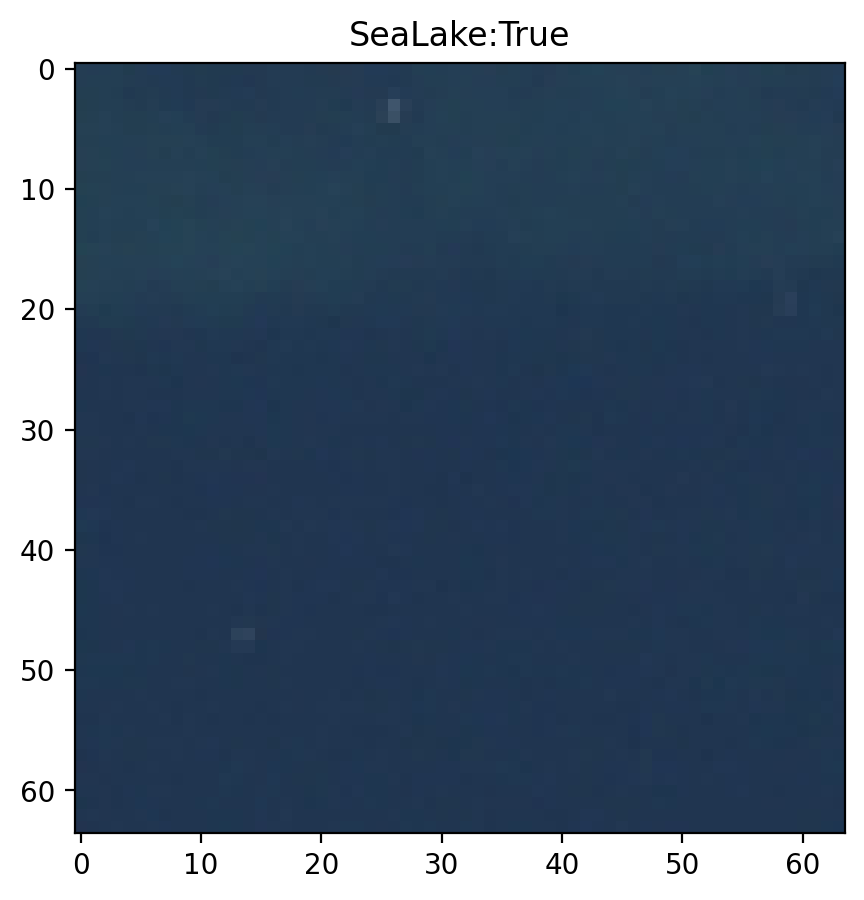

<Figure size 1500x500 with 0 Axes>

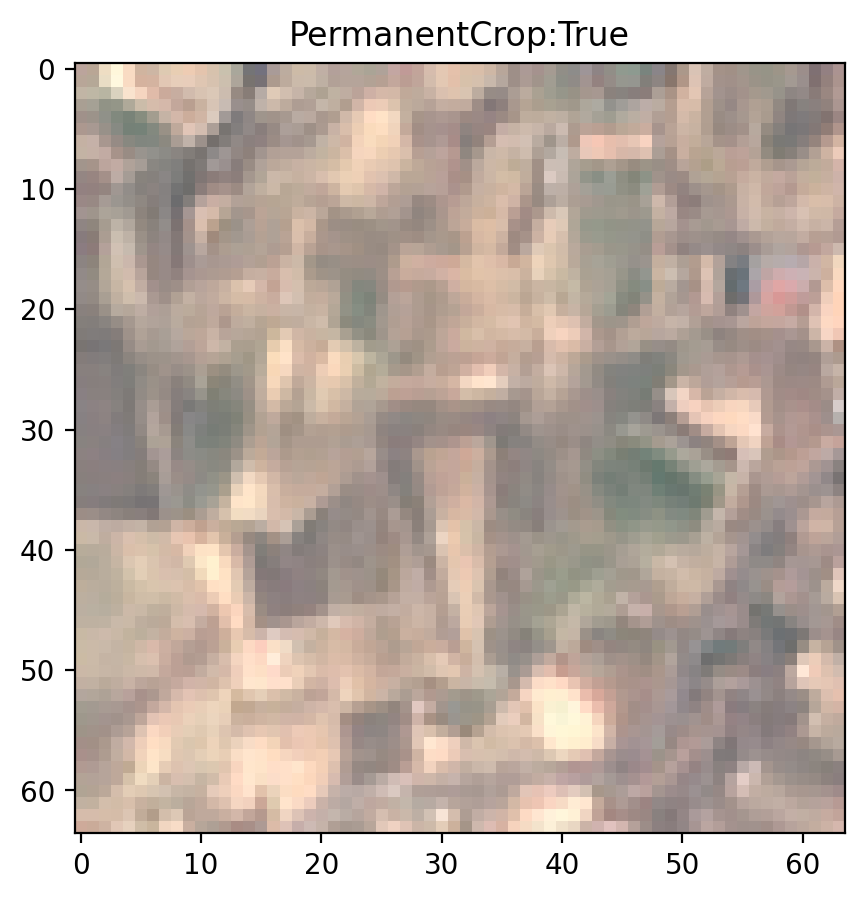

<Figure size 1500x500 with 0 Axes>

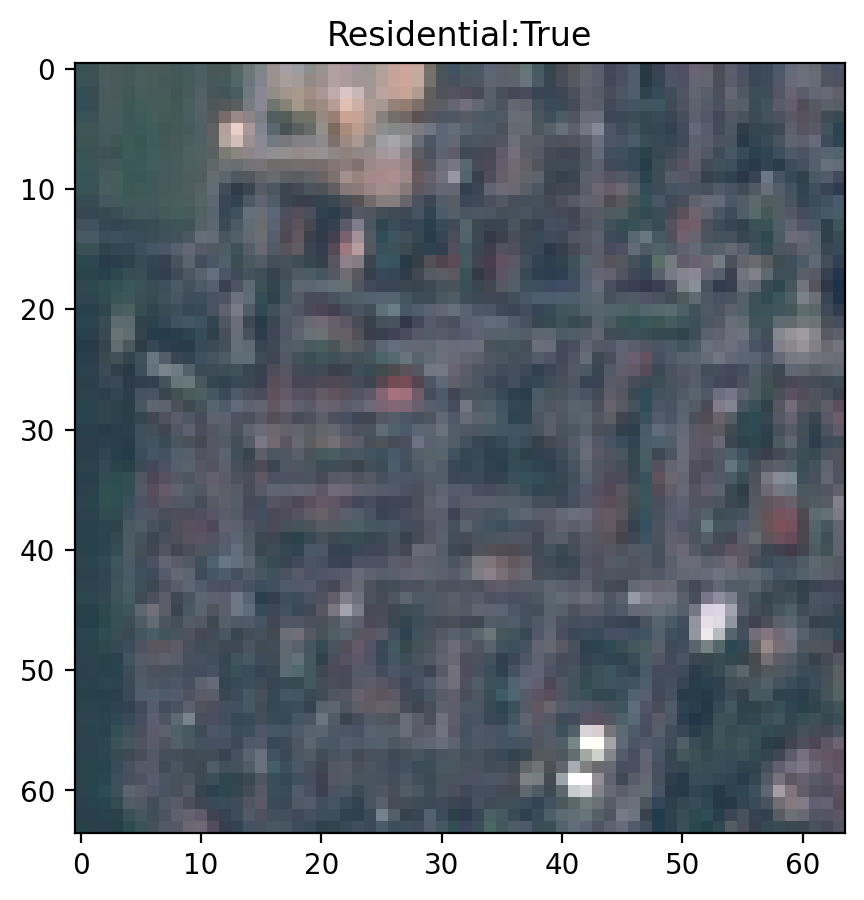

<Figure size 1500x500 with 0 Axes>

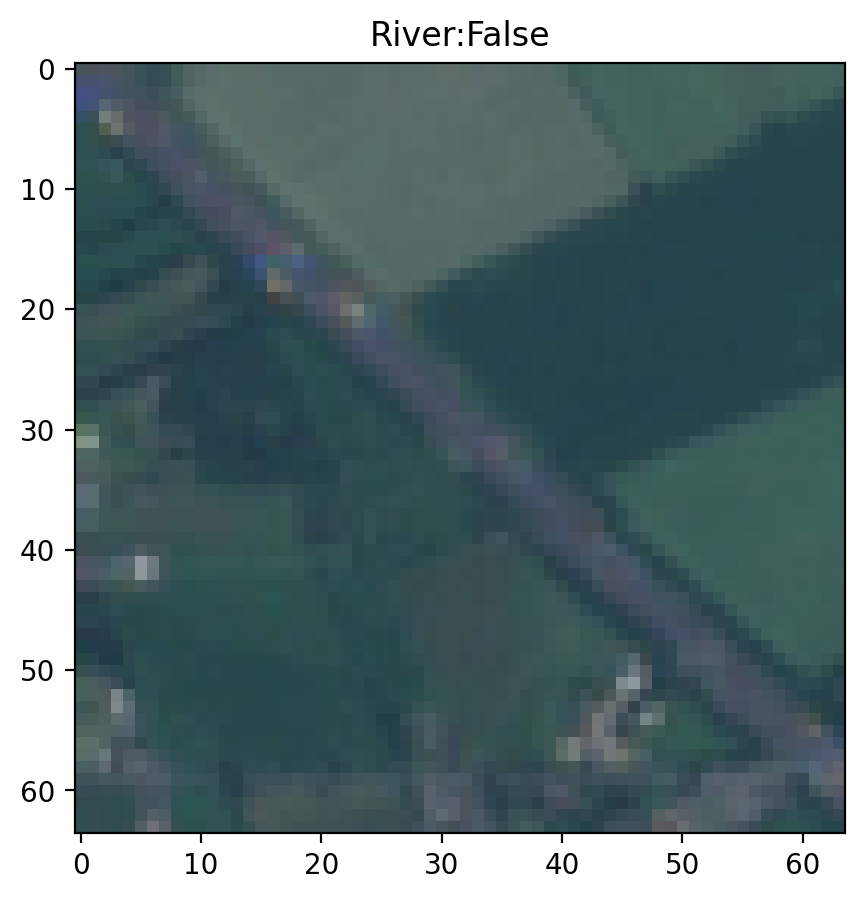

<Figure size 1500x500 with 0 Axes>

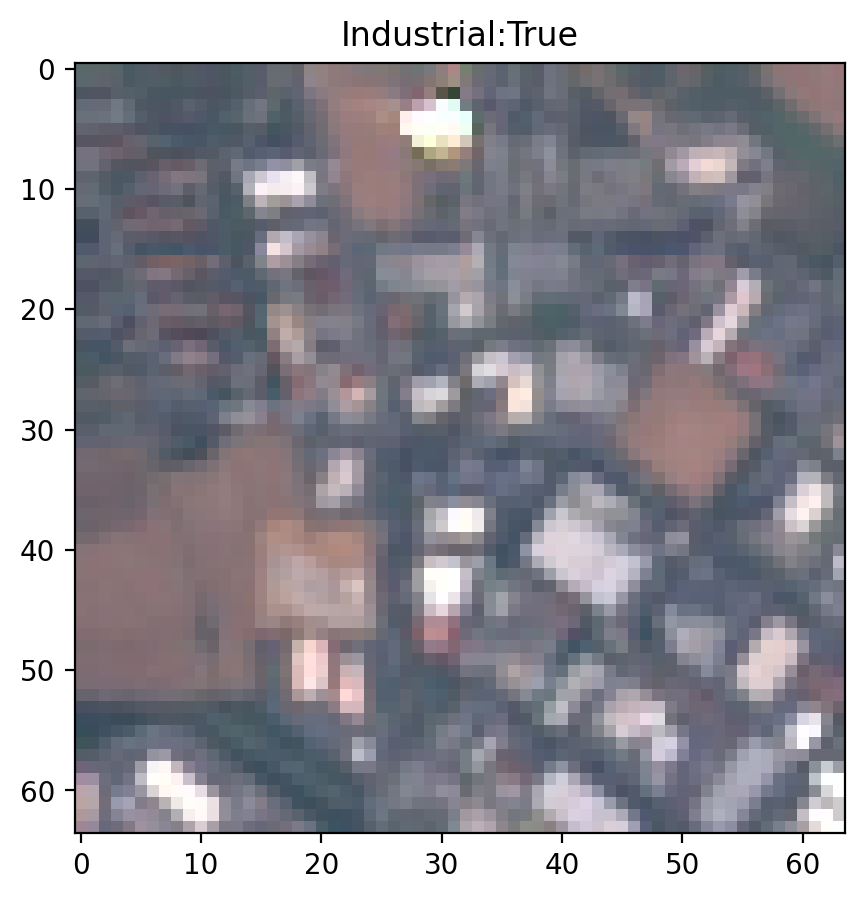

<Figure size 1500x500 with 0 Axes>

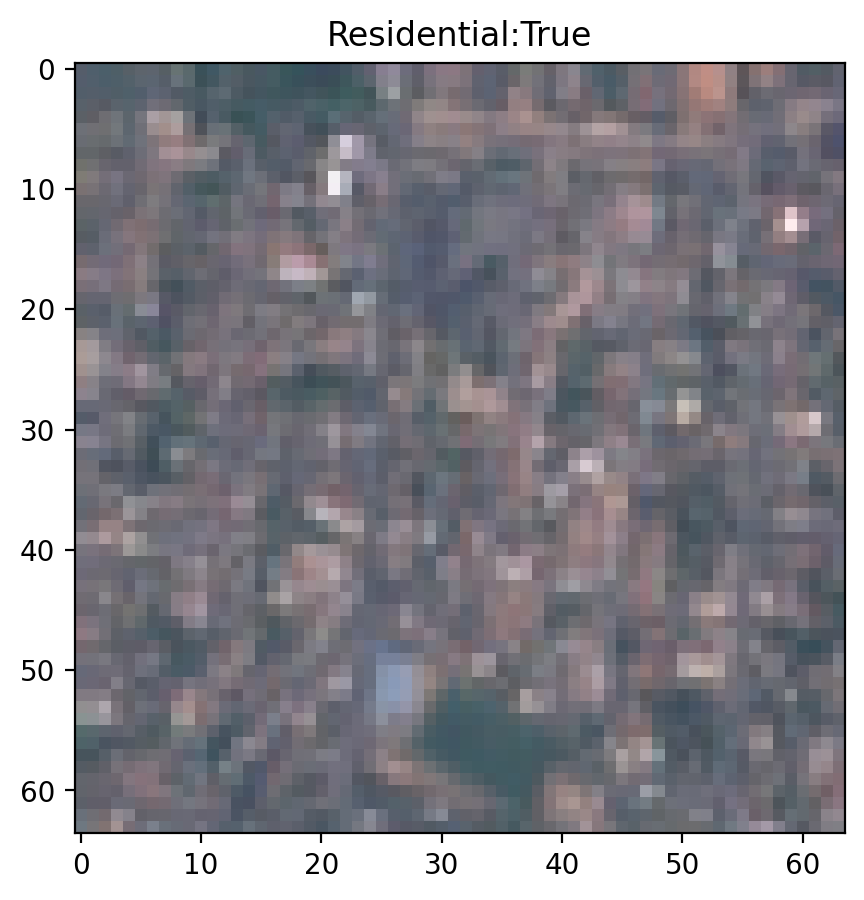

<Figure size 1500x500 with 0 Axes>

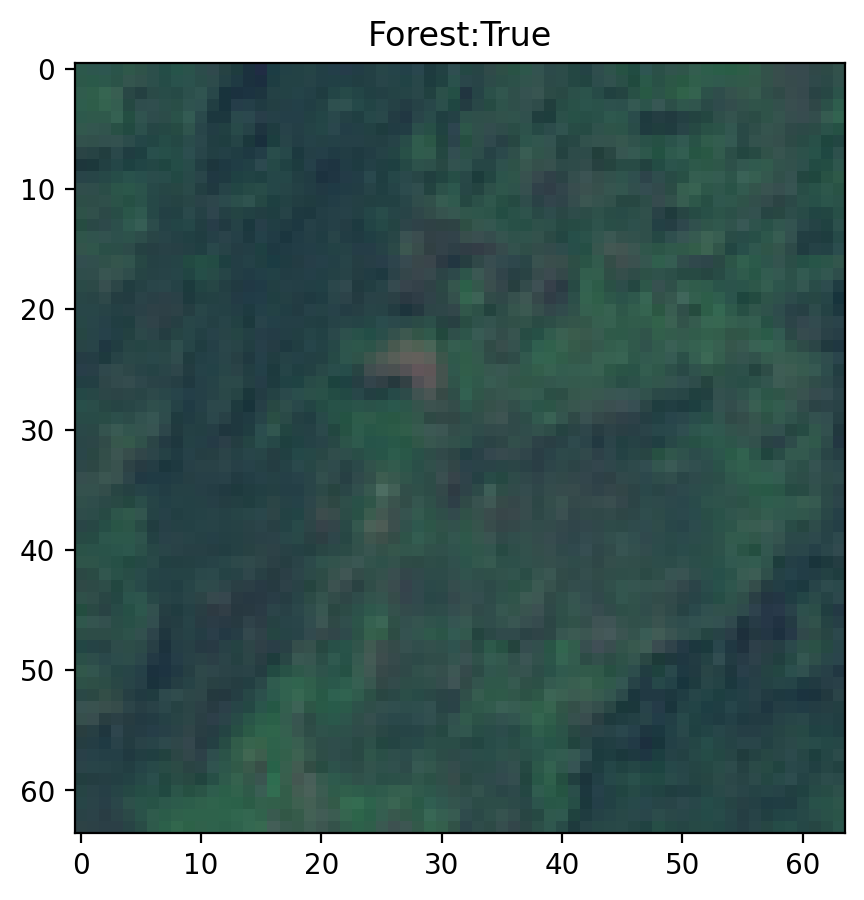

<Figure size 1500x500 with 0 Axes>

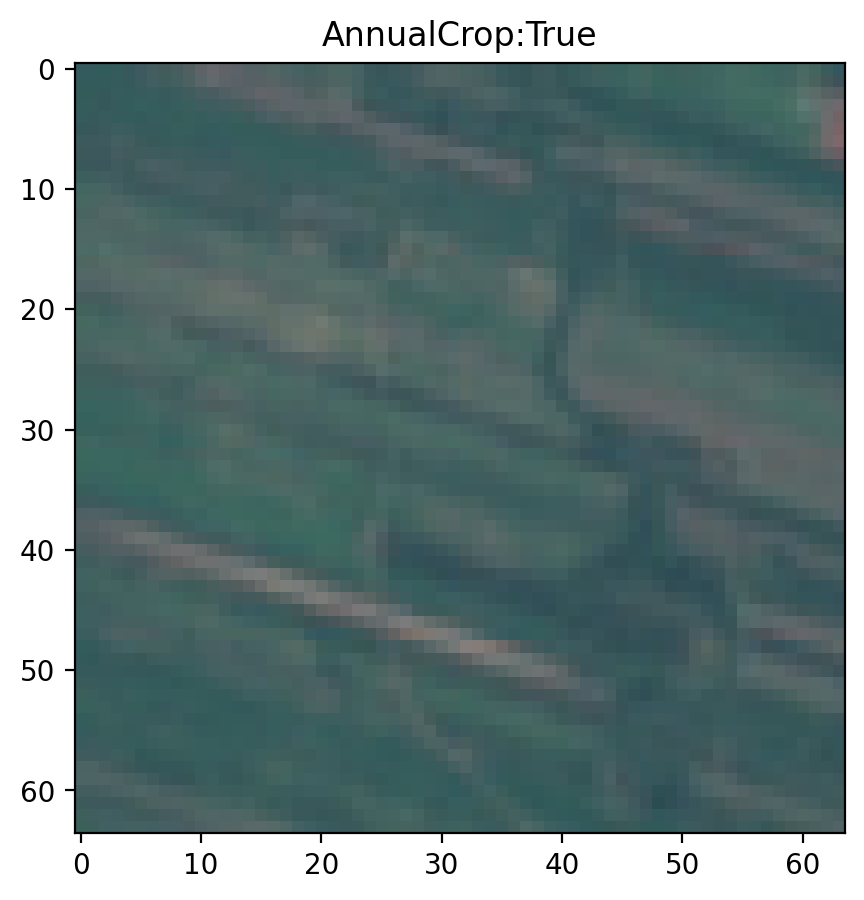

<Figure size 1500x500 with 0 Axes>

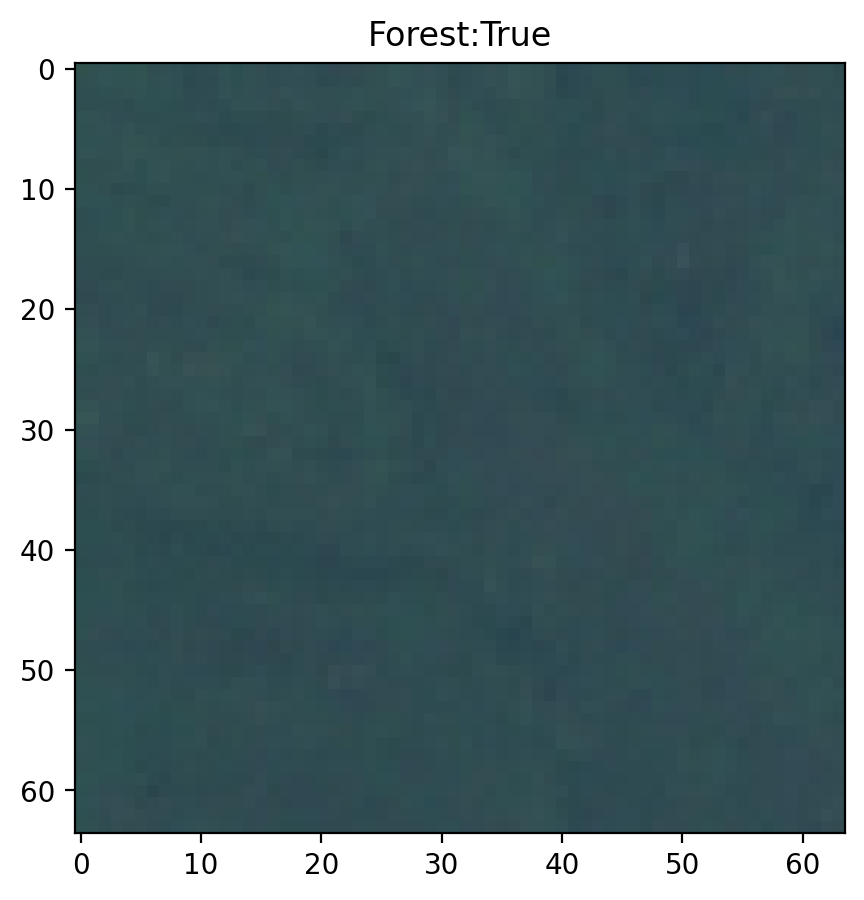

<Figure size 1500x500 with 0 Axes>

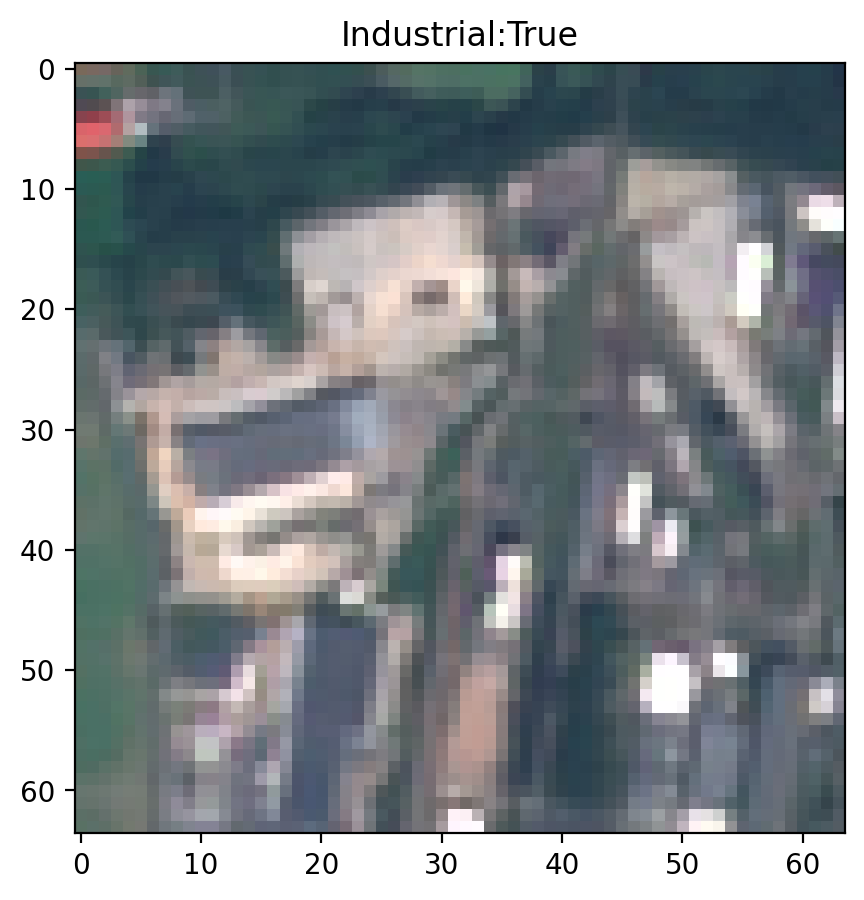

<Figure size 1500x500 with 0 Axes>

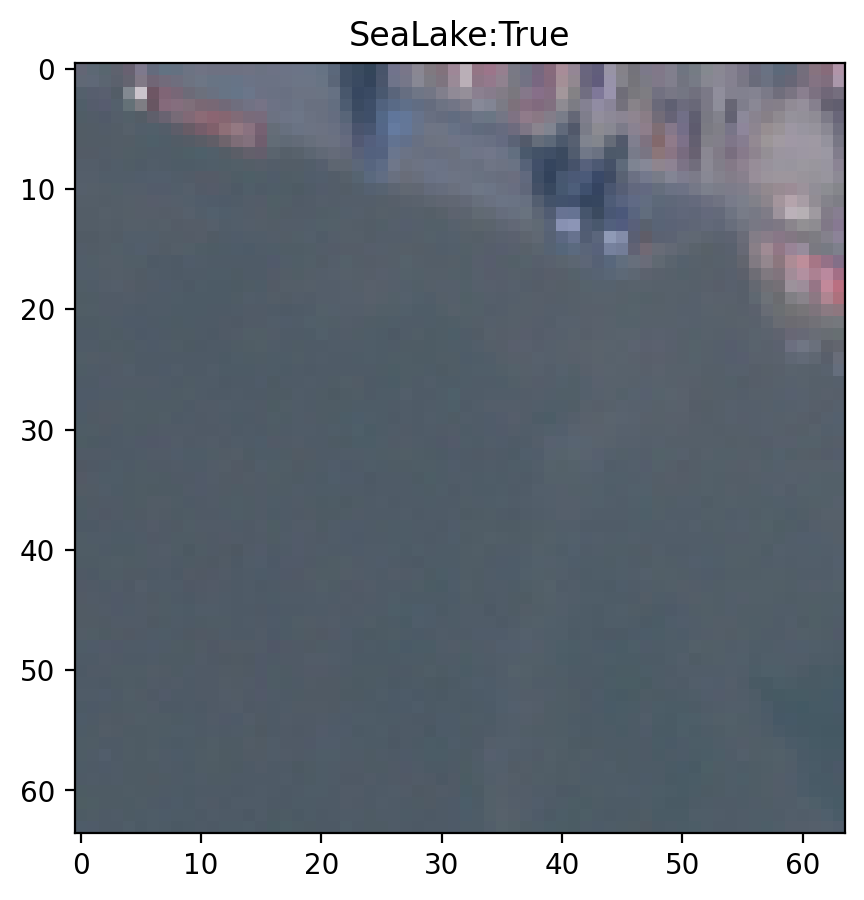

<Figure size 1500x500 with 0 Axes>

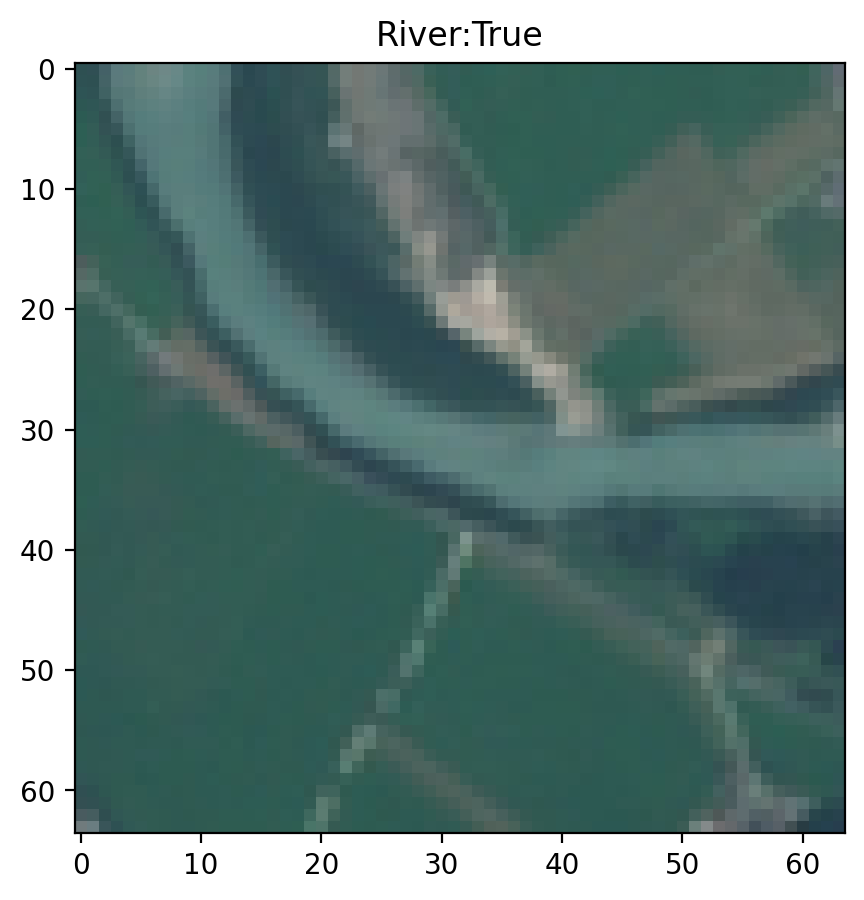

<Figure size 1500x500 with 0 Axes>

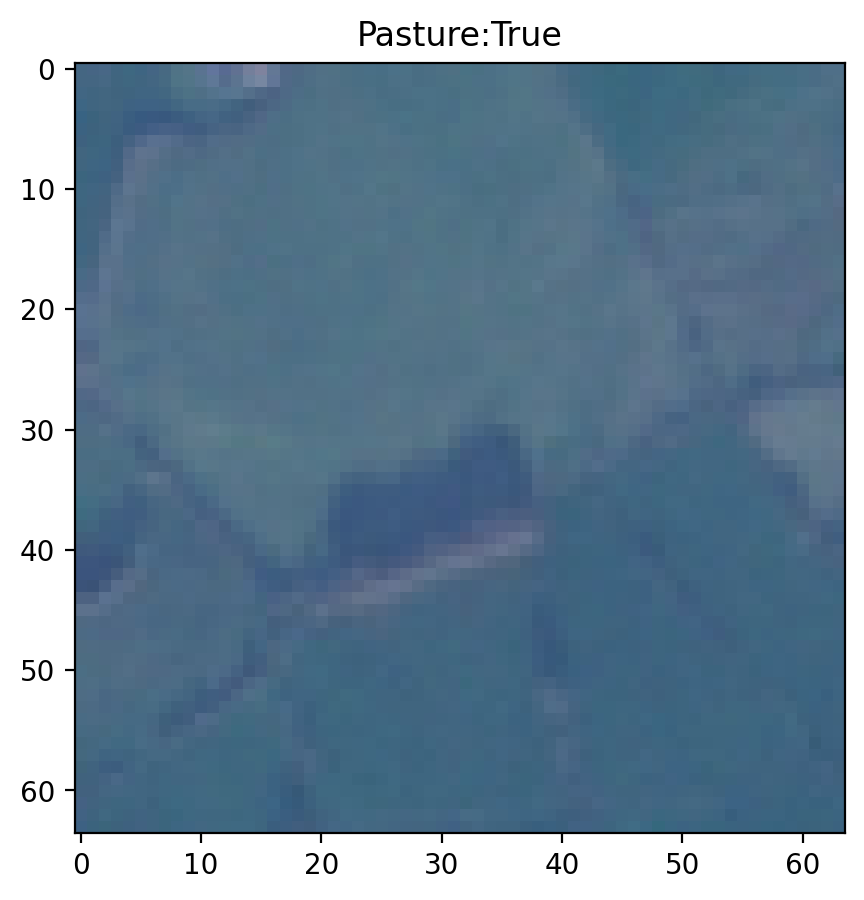

<Figure size 1500x500 with 0 Axes>

In [49]:
to_pil = transforms.ToPILImage()
images, labels,classes = get_random_images(20)
fig=plt.figure(1)

for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    plt.figure()
    plt.title(str(classes[index]) + ":" + str(res))
    plt.imshow(image)
    plt.figure()
plt.show()